<a href="https://colab.research.google.com/github/Divya004/Honours-Project/blob/main/BERT_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://mccormickml.com/2019/07/22/BERT-fine-tuning/


In [49]:
!pip install transformers

In [50]:
!pip install wget

In [51]:
import wget
import os
import os
import re
import csv
import itertools

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

In [52]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [53]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [54]:
import json
import random
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import re
nltk.download("stopwords")
nltk.download('punkt')

with open("/content/drive/MyDrive/train.json", "r") as read_file:
    data = json.load(read_file)

with open("/content/drive/MyDrive/relation2id.json", "r") as read_file:
    data_ids = json.load(read_file)



reduced_sentences = []
removed = 0
file_object = open('reduced_sentences.json', 'a')
file_object.write("{")
'''
para = 'this. is . text.bb'
sent_tokenize(para)
print("cyfcy",sent_tokenize(para))
'''
max_len = 0
max_sent= ""
cut_off = 64
for sentence in data:
    head = sentence["head"]["word"]
    tail = sentence["tail"]["word"]
    para = sentence["sentence"]

    stop_words = set(stopwords.words('english'))

    para = sent_tokenize(para)
    para = [p for p in para if (head in p or tail in p)]
   # print ("after head/tail", para)
    sents = " ".join(para)
    sents = " "+sents
    #print("afterjoin", sents)
    sents = re.sub(r"[^A-Za-z0-9%.-]"," ", sents)
    sents = re.sub(r"\s+", " ", sents)
    words = sents.split()
    filtered_words = [word for word in words if word not in stop_words]
    words = " ".join(filtered_words)
    if (len(words)> cut_off):
      removed += 1
      continue
    if len(words)> max_len:
        max_len= len(words)
        max_sent = words
    if (len(words) == 0):
      print(sentence["sentence"]) 
      print(sents)  
      print (" ")
      continue 
    relation = sentence["relation"]
    if relation in data_ids:
        id = data_ids[relation]
    else:
        id = randint(0,len(data_ids))



    sentence_dict = dict({"head": head, "tail": tail, "sentence":words, "relation": relation, "id":id})

    reduced_sentences.append(sentence_dict)
    file_object.write(json.dumps(sentence_dict))


df = pd.DataFrame(reduced_sentences)
print (max_len,": ", max_sent )
print(df['sentence'])

df.to_pickle("sentences.pkl")
file_object.write("}")
file_object.close()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
64 :  beta-lactams bound either proteins benzyl 14c penicillin bound .
0       beta-lactams bound either proteins benzyl 14c ...
1       veins arteries noradrenaline inactivated rapid...
2       facts suggested aneurysms pseudo-aneurysms sac...
3       average diameter ml 0.5 microgram ul 0.08 micr...
4       protein similar surface protein alpha acinetob...
                              ...                        
3441    norplant system utilizes silastic tubing fille...
3442             mannitol lasix furosemide demonstrated .
3443    orthoclone okt3 muromonab cd3 -- indications m...
3444              betadine 10 per cent pvp-iodine water .
3445    significant differences msc mss pain scores si...
Name: sentence, Length: 3446, dtype: object


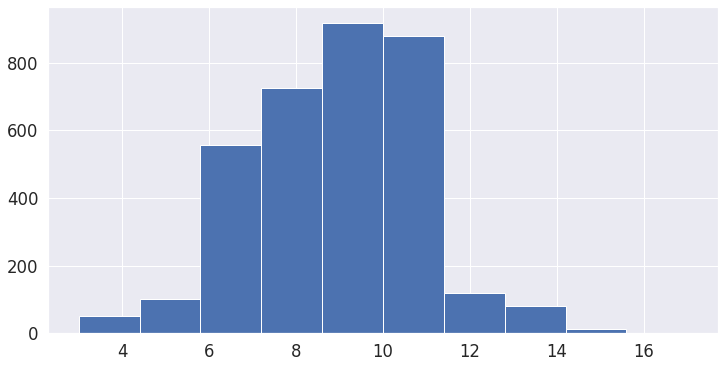

In [55]:
train_text = df['sentence'].values
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist()

In [56]:
for i in range (0,20):
  print(df['sentence'].values[i])

beta-lactams bound either proteins benzyl 14c penicillin bound .
veins arteries noradrenaline inactivated rapidly adrenaline .
facts suggested aneurysms pseudo-aneurysms sacuular aneurysms .
average diameter ml 0.5 microgram ul 0.08 microgram .
protein similar surface protein alpha acinetobacter ssp .
tested dietary lipid changed corn oil butter plus cholesterol .
i. direct anticoagulants heparin synthetic heparinoids .
studies pepsinogen uropepsinogen pediatrics .
detection diatoms marrow sternum evidence death drowning .
activity enterobacteriaceae similar gentamicin less sisomicin .
suggests anion directly attached metal ion protein .
decrease attenuation hematoma time trauma bleeding studied .
comparative study bioavailability digoxin beta methyldigoxin .
mesenteric cysts cysts mesocolon child .
surgical therapy jaw deformities caused cleft lip cleft palate .
antibody reacts antigen prepared four heterologous antigens .
uv sensitivity mt induction greater xp cells nf cells .
presen

In [57]:
print(len(data_ids))

125


In [58]:
# Get the lists of sentences and their labels.
sentences = df['sentence'].values
labels = df['id'].values
classes = len(data_ids)

In [59]:
print(sentences[0])

beta-lactams bound either proteins benzyl 14c penicillin bound .


In [60]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [61]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    

print('Max sentence length: ', max_len)

Max sentence length:  33


In [62]:
max_len = 64

In [63]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  beta-lactams bound either proteins benzyl 14c penicillin bound .
Token IDs: tensor([  101,  8247,  1011, 18749, 15464,  2015,  5391,  2593,  8171, 17770,
         8516,  2403,  2278,  7279, 28775, 21202,  5391,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [64]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,101 training samples
  345 validation samples


In [65]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [66]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = classes, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    hidden_dropout_prob=0.5
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [67]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [68]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [69]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 8

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [70]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [71]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [72]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,return_dict = False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict = False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:26.
  Batch    80  of     97.    Elapsed: 0:00:52.

  Average training loss: 3.63
  Training epoch took: 0:01:03

Running Validation...
  Accuracy: 0.27
  Validation Loss: 3.09
  Validation took: 0:00:02

======== Epoch 2 / 8 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:26.
  Batch    80  of     97.    Elapsed: 0:00:52.

  Average training loss: 3.05
  Training epoch took: 0:01:03

Running Validation...
  Accuracy: 0.30
  Validation Loss: 2.92
  Validation took: 0:00:02

======== Epoch 3 / 8 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:26.
  Batch    80  of     97.    Elapsed: 0:00:52.

  Average training loss: 2.85
  Training epoch took: 0:01:03

Running Validation...
  Accuracy: 0.31
  Validation Loss: 2.78
  Validation took: 0:00:02

======== Epoch 4 / 8 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:26.
  Batch    80  of     97.    Elapsed: 0:

In [98]:
!pip install torchinfo
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           96,125
Total params: 1

In [73]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.63,3.09,0.27,0:01:03,0:00:02
2,3.05,2.92,0.30,0:01:03,0:00:02
3,2.85,2.78,0.31,0:01:03,0:00:02
4,2.71,2.71,0.33,0:01:03,0:00:02
5,2.63,2.62,0.32,0:01:03,0:00:02
6,2.58,2.58,0.33,0:01:03,0:00:02
7,2.50,2.52,0.37,0:01:03,0:00:02
8,2.46,2.51,0.35,0:01:03,0:00:02


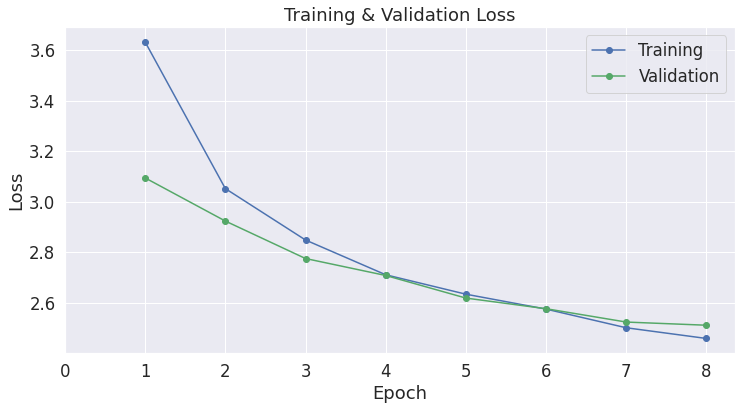

In [74]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0,1, 2, 3, 4,5, 6,7, 8])

plt.show()


In [75]:
torch.save(model.state_dict(), "BERT_7.h5")

Testing

In [76]:
import json

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import re
nltk.download("stopwords")
nltk.download('punkt')

with open("/content/drive/MyDrive/test.json", "r") as read_file:
    test_data = json.load(read_file)





reduced_train_sentences = []
removed = 0
file_object = open('reduced_sentences.json', 'a')
file_object.write("{")

max_len = 0
max_sent= ""
cut_off = 64
for sentence in test_data:
    head = sentence["head"]["word"]
    tail = sentence["tail"]["word"]
    para = sentence["sentence"]

    stop_words = set(stopwords.words('english'))

    para = sent_tokenize(para)
    para = [p for p in para if (head in p or tail in p)]
   # print ("after head/tail", para)
    sents = " ".join(para)
    sents = " "+sents
    #print("afterjoin", sents)
    sents = re.sub(r"[^A-Za-z0-9%.-]"," ", sents)
    sents = re.sub(r"\s+", " ", sents)
    words = sents.split()
    filtered_words = [word for word in words if word not in stop_words]
    words = " ".join(filtered_words)
    if (len(words)> cut_off):
      removed += 1
      continue
    if len(words)> max_len:
        max_len= len(words)
        max_sent = words
    if (len(words) == 0):
      print(sentence["sentence"]) 
      print(sents)  
      print (" ")
      continue 
    relation = sentence["relation"]
    if relation in data_ids:
        id = data_ids[relation]
    else:
        id = 0



    train_sentence_dict = dict({"head": head, "tail": tail, "sentence":words, "relation": relation, "id":id})

    reduced_train_sentences.append(train_sentence_dict)
    file_object.write(json.dumps(train_sentence_dict))


train_df = pd.DataFrame(reduced_train_sentences)
print (max_len,": ", max_sent )
print(train_df['sentence'])

train_df.to_pickle("train_sentences.pkl")
file_object.write("}")
file_object.close()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
64 :  messenger rna specified arom locus detected 5.3 kb rna species .
0      mics cfm cpz ctx mox much higher 1 000 4 000 f...
1      lipid region lps glycan backbone pg chemical a...
2                      action adrenaline noradrenaline .
3        3. effect polysomal ribosomal rna soluble rna .
4      proteins fraction acidic h. cutirubrum ribosom...
                             ...                        
737    accompanied increase red cell k content 2 3-dp...
738    thus hypothalamic timer starts time gnrh secre...
739       10 days decreased hypothalamic lh-rh content .
740    human hypothalamic lhrh precursor size rat mou...
741    zovirax cream 5.0 % acyclovir applied five tim...
Name: sentence, Length: 742, dtype: object


In [77]:
print('Number of test sentences: ', len(reduced_train_sentences))

Number of test sentences:  742


In [78]:

# Create sentence and label lists
train_sentences = train_df['sentence'].values
train_labels = train_df['id'].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [79]:
# Prediction on test set
from numpy import argmax

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

p, actuals = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]


  yhat = logits.detach().cpu().numpy()
  actual = b_labels.to('cpu').numpy()
  # convert to class labels
  yhat = argmax(yhat, axis=1)
  # reshape for stacking
  actual = actual.reshape((len(actual), 1))
  #yhat = yhat.reshape((len(yhat), 1))
  # store
  p.append(yhat)
  actuals.append(actual)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 742 test sentences...
    DONE.


In [80]:
# !print('Positive samples: %d of %d (%.2f%%)' % (train_df['id'].sum(), len(train_df['id']), (train_df["id"].sum() / len(train_df['id']) * 100.0)))

In [81]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


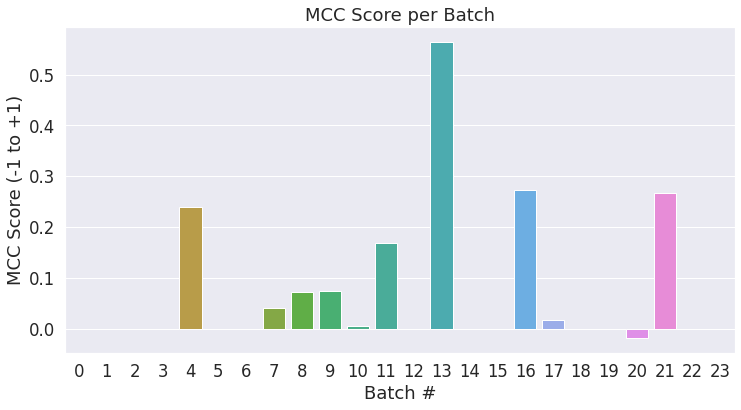

In [82]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [83]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)



Total MCC: 0.296


In [84]:
from sklearn.metrics import f1_score

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions, average="macro")

print('F1 Score: %.3f' % f1)

F1 Score: 0.041


In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

cm = confusion_matrix(flat_true_labels, flat_predictions)
print(cm)

[[112   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  4   0   0 ...   0   0   0]
 [  3   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]]


In [86]:
text_labels = [x for x in data_ids]


In [87]:

correct_classes = [0 for _ in cm]
for r in range(len(cm)):
  correct_classes[r] = cm[r][r]


In [88]:
for i in range(len(correct_classes)):
  if correct_classes[i] != 0:
    print(text_labels[i], " correctly classified ", correct_classes[i], " times")

active_metabolites_of  correctly classified  112  times
anatomy_originated_from_biological_process  correctly classified  21  times
associated_with_malfunction_of_gene_product  correctly classified  11  times
chemical_or_drug_is_product_of_biological_process  correctly classified  4  times
disease_has_normal_cell_origin  correctly classified  37  times
disease_has_normal_tissue_origin  correctly classified  80  times
excised_anatomy_has_procedure  correctly classified  1  times
gene_product_is_physical_part_of  correctly classified  16  times


In [89]:
c =0
for i in range(len(correct_classes)):
  if correct_classes[i] == 0 and c<5:
    c+=1
    print(text_labels[i], " correctly classified ", correct_classes[i], " times")

anatomic_structure_has_location  correctly classified  0  times
anatomic_structure_is_physical_part_of  correctly classified  0  times
biological_process_has_associated_location  correctly classified  0  times
biological_process_has_initiator_chemical_or_drug  correctly classified  0  times
biological_process_has_initiator_process  correctly classified  0  times


In [104]:
print ("f1 score of model is :",f1_score(flat_true_labels, flat_predictions, average="macro"))
print ("Precision score of model is :",precision_score(flat_true_labels, flat_predictions, average="macro"))
print ("Recall score of model is :",recall_score(flat_true_labels, flat_predictions, average="macro"))
print("Accuracy of model is :",accuracy_score(flat_true_labels, flat_predictions))

f1 score of model is : 0.04145087581544001
Precision score of model is : 0.047883063671298284
Recall score of model is : 0.05360038885384877
Accuracy of model is : 0.38005390835579517


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# create new data structure st [entity 1, entitiy 2, label]
# match predicted label to text label (somehow)(should be index of data_id tbh)
# use the plot graph function in one of your way too many open tabs
# seriously girl close some tabs
#also frist print predictions to get a feel of it bc something does not feel right

In [92]:
import networkx as nx
def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=100, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()


In [93]:
i = 0
for ind in train_df.index:
  i += 1

print(i == len(flat_predictions))  

True


In [94]:
triples = []
for ind in train_df.index:
     triples.append((train_df['head'][ind],text_labels[flat_predictions[ind ]], train_df['tail'][ind]))

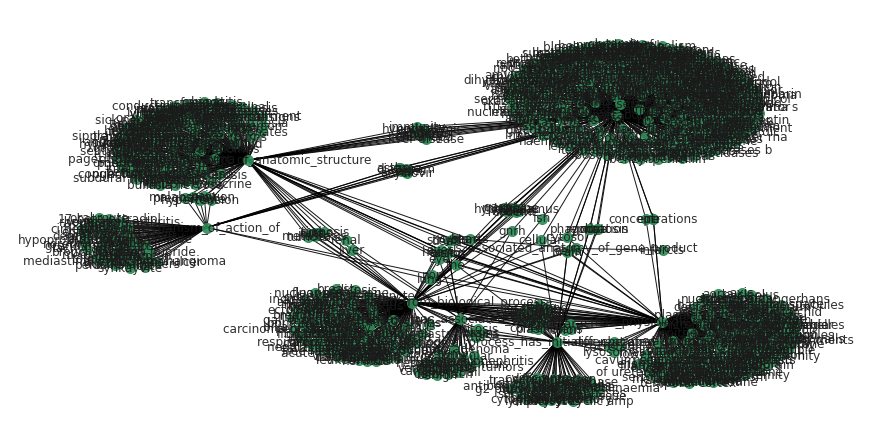

In [95]:
 printGraph(triples)

Correct:


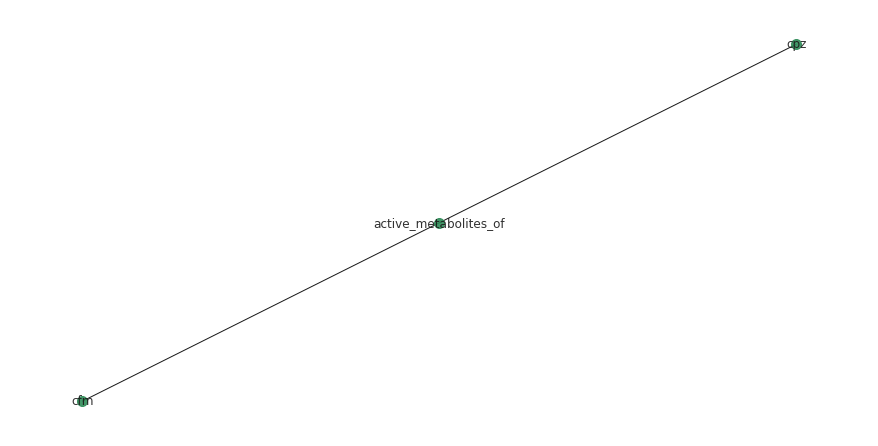

Incorrect:


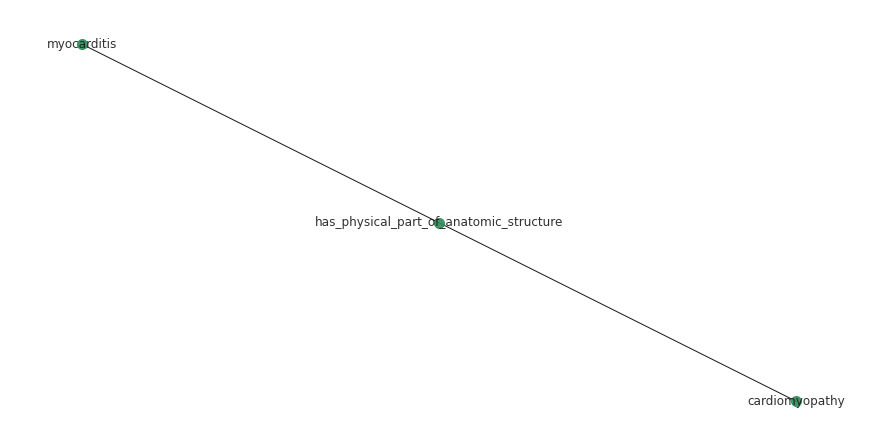

Incorrect:


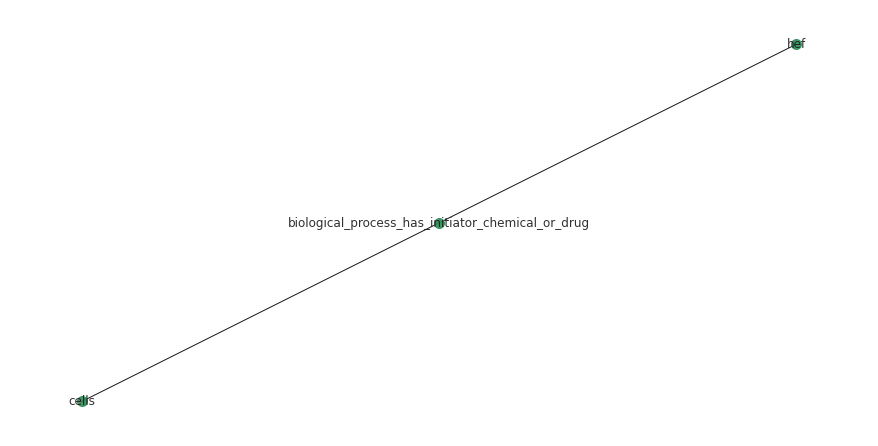

Incorrect:


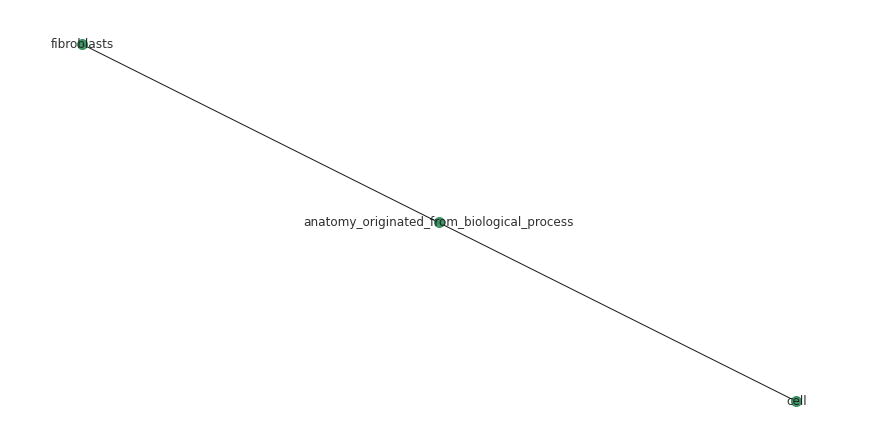

Incorrect:


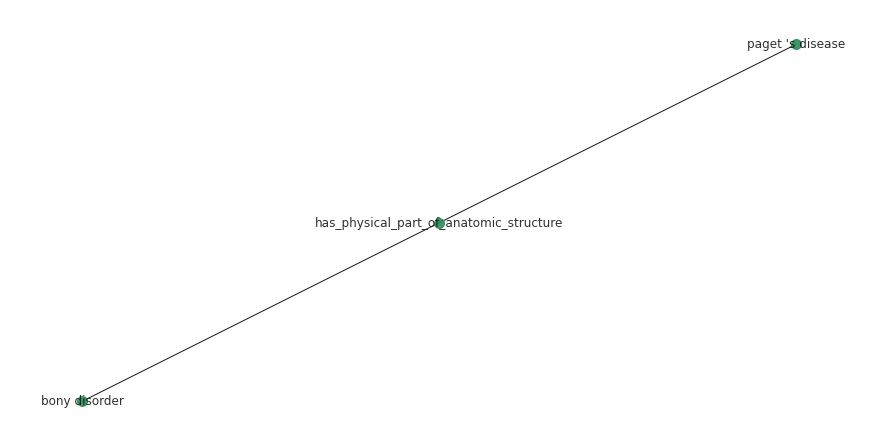

Incorrect:


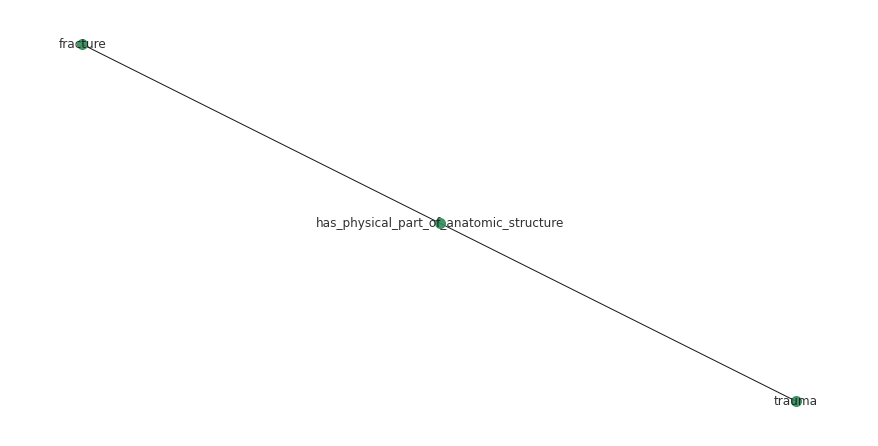

Incorrect:


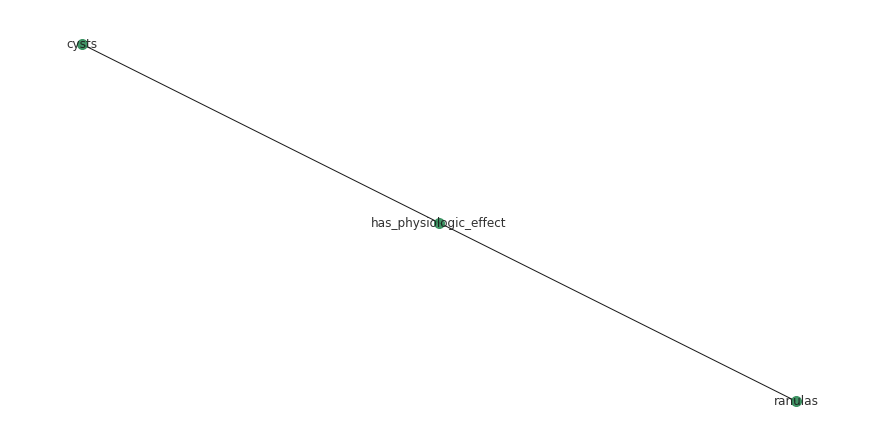

Correct:


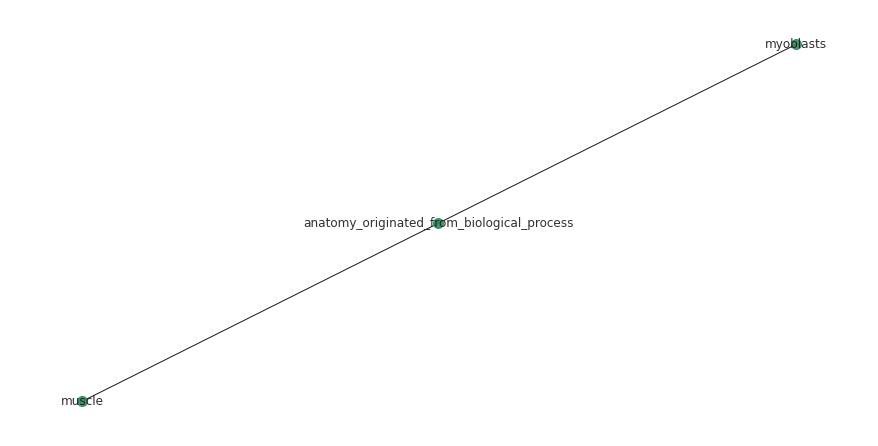

Correct:


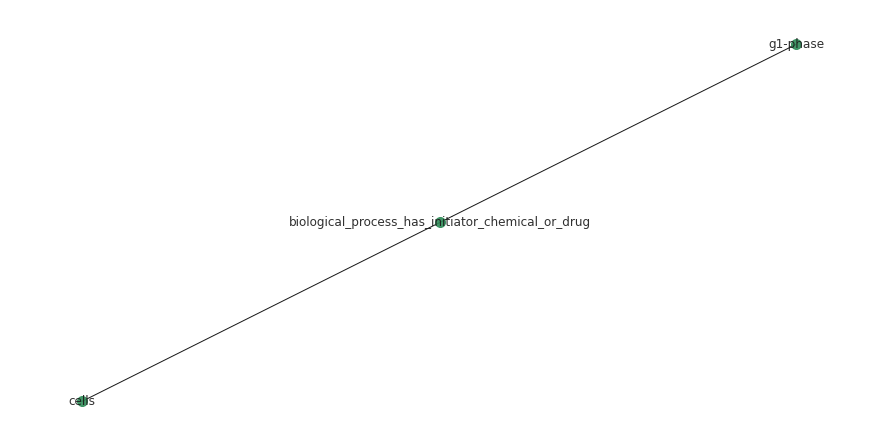

Correct:


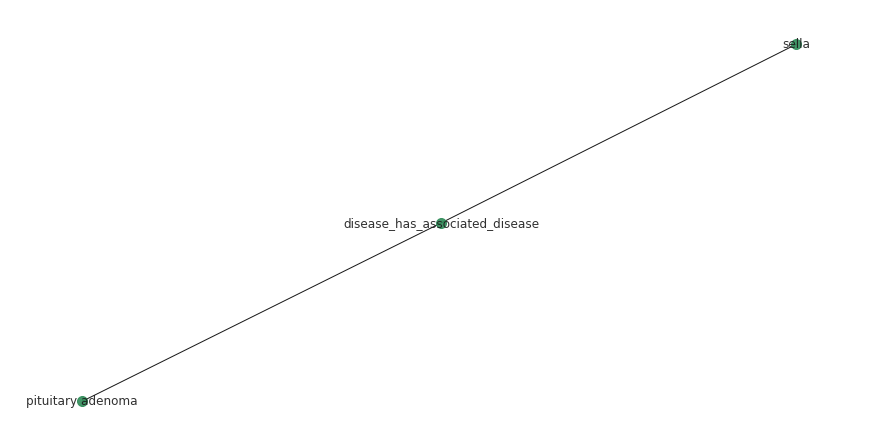

Correct:


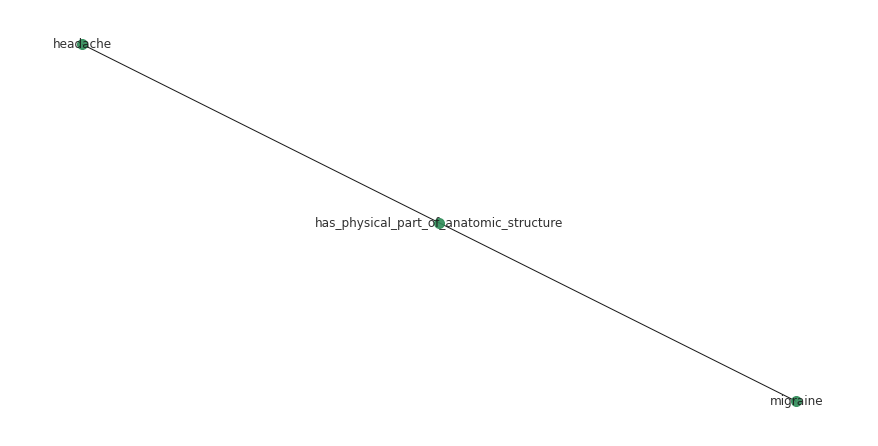

Correct:


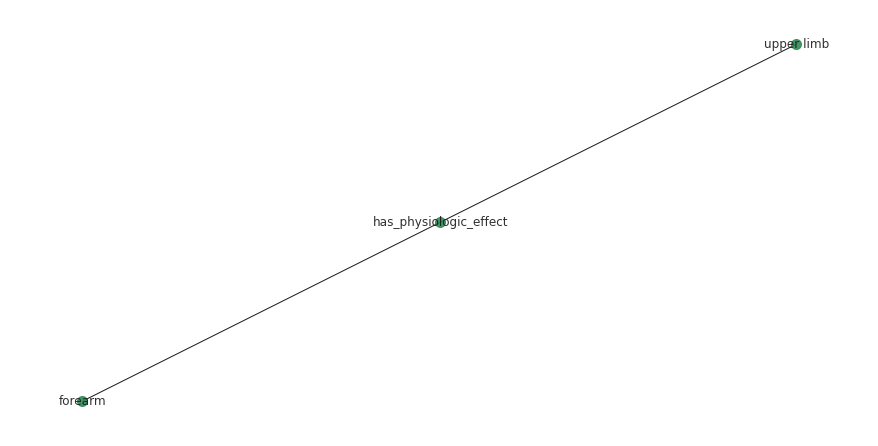

In [100]:
num_incorrect = 0
num_correct = set()
for ind in train_df.index:
  if (flat_predictions[ind]== train_df['id'][ind] and len(num_correct)<=5 and not(train_df['id'][ind] in num_correct) ):
    num_correct.add(train_df['id'][ind]) 

    print("Correct:")
    printGraph([(train_df['head'][ind],text_labels[flat_predictions[ind ]], train_df['tail'][ind])])
  else:
    if (flat_predictions[ind]!= train_df['id'][ind] and num_incorrect<=5):
      num_incorrect +=1
      print("Incorrect:")
      printGraph([(train_df['head'][ind],text_labels[flat_predictions[ind ]], train_df['tail'][ind])])  
  if len(num_correct) >5 and num_incorrect >5:
    break   

In [102]:
for ind in train_df.index:
  if (41== flat_predictions[ind ] ):
  
    printGraph([(train_df['head'][ind],text_labels[flat_predictions[ind ]], train_df['tail'][ind])])